# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Daffa Aprilian Herdikaputra
- **Email:** daffaherdika46@gmail.com
- **ID Dicoding:** daffaherdika

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


### Data Preprocessing

#### Split Dataset

In [4]:
# Path asli dataset kamu
base_dir = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'

# Path tujuan
target_dir = '/kaggle/working/data'

# Membuat folder train, validation, test
for split in ['train', 'validation', 'test']:
    for category in ['Cat', 'Dog']:
        os.makedirs(os.path.join(target_dir, split, category), exist_ok=True)

# Setting rasio pembagian
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Fungsi untuk membagi dan menyalin file
def split_data(class_name):
    source_folder = os.path.join(base_dir, class_name)
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    # Buang file corrupt jika ada
    files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]

    random.shuffle(files)

    total = len(files)
    train_count = int(total * train_split)
    val_count = int(total * val_split)

    train_files = files[:train_count]
    val_files = files[train_count:train_count+val_count]
    test_files = files[train_count+val_count:]

    # Copy file ke folder yang sesuai
    for f in train_files:
        shutil.copy(os.path.join(source_folder, f), os.path.join(target_dir, 'train', class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(source_folder, f), os.path.join(target_dir, 'validation', class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(source_folder, f), os.path.join(target_dir, 'test', class_name, f))

# Bagi data untuk masing-masing class
split_data('Cat')
split_data('Dog')

In [5]:
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/validation'
test_dir = '/kaggle/working/data/test'

In [6]:
for split in ['train', 'validation', 'test']:
    for category in ['Cat', 'Dog']:
        folder_path = os.path.join(target_dir, split, category)
        print(f"Jumlah {split} {category}: {len(os.listdir(folder_path))}")

Jumlah train Cat: 11988
Jumlah train Dog: 12028
Jumlah validation Cat: 2372
Jumlah validation Dog: 2382
Jumlah test Cat: 2374
Jumlah test Dog: 2385


## Modelling

In [7]:
# Membuat model sequential
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # agar tidak overfitting
    Dense(1, activation='sigmoid')  # karena binary classification (Cat vs Dog)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Menampilkan summary model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # /kaggle/working/data/train
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,  # /kaggle/working/data/validation
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 24016 images belonging to 2 classes.
Found 4754 images belonging to 2 classes.


In [9]:
#Training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/751 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.5772 - loss: 0.6923

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


751/751 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - accuracy: 0.6090 - loss: 0.6600 - val_accuracy: 0.7907 - val_loss: 0.4602
Epoch 2/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - accuracy: 0.7779 - loss: 0.4657 - val_accuracy: 0.8416 - val_loss: 0.3586
Epoch 3/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - accuracy: 0.8276 - loss: 0.3836 - val_accuracy: 0.8843 - val_loss: 0.2815
Epoch 4/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 78s 66ms/step - accuracy: 0.8702 - loss: 0.2997 - val_accuracy: 0.9154 - val_loss: 0.2216
Epoch 5/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - accuracy: 0.9146 - loss: 0.2083 - val_accuracy: 0.9394 - val_loss: 0.1614
Epoch 6/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.9489 - loss: 0.1349 - val_accuracy: 0.9598 - val_loss: 0.1306
Epoch 7/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.9702 - loss: 0.0877 - val_accuracy: 0.9720 - val_loss: 0.1096
Epoch 8/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.9780 - loss: 0.0641 - val_accurac

## Evaluasi dan Visualisasi

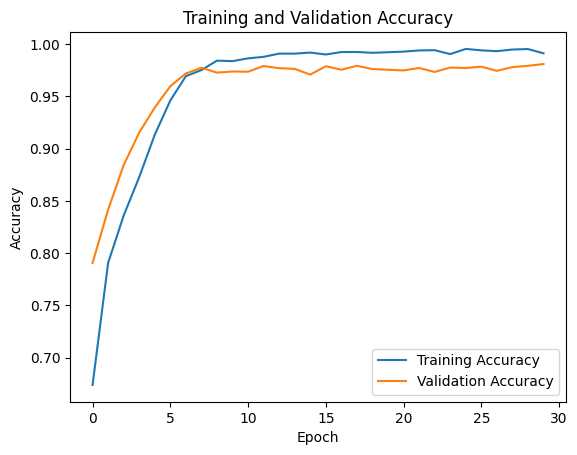

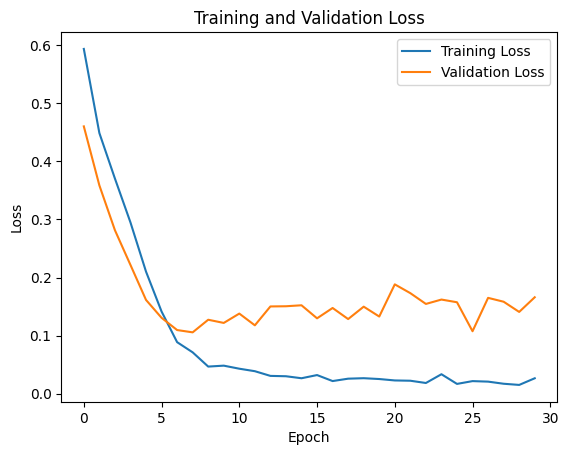

In [10]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Membuat data augmentasi untuk test (tanpa validasi split)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat test generator tanpa subset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4759 images belonging to 2 classes.


In [12]:
# Evaluasi model dengan test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9765 - loss: 0.2294
Test Accuracy: 97.94%


## Konversi Model

In [16]:
# 1. install package tambahan
!pip install tensorflowjs

# 2. Import library
import tensorflow as tf
import tensorflowjs as tfjs
import os

# 3. Buat folder submission
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

# 4. EXPORT ke SavedModel
model.export("submission/saved_model")

# 5. EXPORT ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Membuat file label.txt
with open("submission/tflite/label.txt", "w") as f:
    f.write("0: Cat\n1: Dog")

# 6. EXPORT ke TFJS
tfjs.converters.save_keras_model(model, "submission/tfjs_model")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132281699588368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696394640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696395216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696401936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696399824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696402896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696402320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281696401744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281694552336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281694553872: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved arti

failed to lookup keras version from the file,
    this is likely a weight only file


In [17]:

# zip folder submission
!zip -r submission.zip submission/

# tampilkan link untuk download
from google.colab import files
files.download("submission.zip")


  adding: submission/ (stored 0%)
  adding: submission/tflite/ (stored 0%)
  adding: submission/tflite/model.tflite (deflated 7%)
  adding: submission/tflite/label.txt (stored 0%)
  adding: submission/tfjs_model/ (stored 0%)
  adding: submission/tfjs_model/group1-shard15of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard18of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard9of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard8of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard19of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard7of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard10of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard12of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard14of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard5of19.bin (deflated 6%)
  adding: submission/tfjs_model/group1-shard11of19.bin (deflated 6%)
  adding: submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [25]:

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()

# Get input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Buat data dummy
dummy_input = np.random.random(input_details[0]['shape']).astype(np.float32)

# Set input ke interpreter
interpreter.set_tensor(input_details[0]['index'], dummy_input)

# Run inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])

print("Hasil Inference:", output_data)


Hasil Inference: [[0.9556939]]
